In [1]:
import numpy as np
import collections

class ScratchDecisionTreeClassifier:
    def __init__(self, verbose=False):
        self.verbose = verbose
#[Problem 1] Function for finding impureness
    def _calc_gini(self, y):
        labels, counts = np.unique(y, return_counts=True)
        prob_sq_sum = np.sum((counts / np.sum(counts)) ** 2)
        return 1 - prob_sq_sum

#[Problem 2] Function for finding information gain
    def _calc_ig(self, X, feature_index, y, threshold):
        labels_l = y[X[:, feature_index] < threshold]
        labels_r = y[X[:, feature_index] >= threshold]

        if len(labels_l) == 0 or len(labels_r) == 0:
            return 0

        gini_l = self._calc_gini(labels_l)
        gini_r = self._calc_gini(labels_r)
        total = len(y)

        weighted_gini = (len(labels_l) / total) * gini_l + (len(labels_r) / total) * gini_r
        return self._calc_gini(y) - weighted_gini
#[Problem 3] Learning
    def fit(self, X, y):
        self.gain = 0
        for feature_index in range(X.shape[1]):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                _gain = self._calc_ig(X, feature_index, y, threshold)
                if _gain > self.gain:
                    self.gain = _gain
                    self.feature = feature_index
                    self.threshold = threshold
                    self.l_label = collections.Counter(
                        y[X[:, feature_index] < threshold]
                    ).most_common(1)[0][0]
                    self.r_label = collections.Counter(
                        y[X[:, feature_index] >= threshold]
                    ).most_common(1)[0][0]
                    if self.verbose:
                        print(
                            f"feature={self.feature}, threshold={self.threshold}, gain={self.gain}"
                        )
#[Problem 4] Estimate
    def predict(self, X):
        preds = []
        for sample in X:
            if sample[self.feature] < self.threshold:
                preds.append(self.l_label)
            else:
                preds.append(self.r_label)
        return np.array(preds)


In [3]:
#[Problem 5] Learning and estimation

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = ScratchDecisionTreeClassifier(verbose=True)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

feature=0, threshold=-1.8506409892206923, gain=0.00664952531645574
feature=0, threshold=-1.7396379947212464, gain=0.01346955128205135
feature=0, threshold=-1.6845076973356652, gain=0.020466720779220793
feature=0, threshold=-1.6416247924569927, gain=0.02764802631578961
feature=0, threshold=-1.5355611804303309, gain=0.03502083333333328
feature=0, threshold=-1.4753391527670985, gain=0.042592905405405446
feature=0, threshold=-1.4666216105885124, gain=0.05037243150684939
feature=0, threshold=-1.4418909621618134, gain=0.05836805555555563
feature=0, threshold=-1.422031642583927, gain=0.06658890845070425
feature=0, threshold=-1.3641913196689681, gain=0.07504464285714296
feature=0, threshold=-1.2993617873714682, gain=0.08374547101449281
feature=0, threshold=-1.2391225600617886, gain=0.092702205882353
feature=0, threshold=-1.2301755468806426, gain=0.10192630597014929
feature=0, threshold=-1.2125878069874894, gain=0.11142992424242437
feature=0, threshold=-1.2037692726248406, gain=0.12122596153846

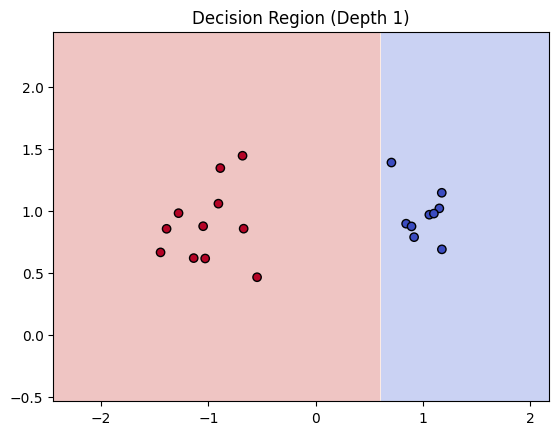

In [4]:
#[Problem 6] Visualization of decision area
import matplotlib.pyplot as plt

def plot_decision_region(X, y, model, title='Decision Region'):
    x0_range = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300)
    x1_range = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    xx0, xx1 = np.meshgrid(x0_range, x1_range)
    grid = np.c_[xx0.ravel(), xx1.ravel()]

    pred = model.predict(grid).reshape(xx0.shape)

    plt.contourf(xx0, xx1, pred, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title(title)
    plt.show()

plot_decision_region(X_test, y_test, tree, title="Decision Region (Depth 1)")


In [5]:
#[Problem 7] (Advance assignment) Creation of a decision tree classifier class with a depth of 2
class ScratchDecisionTreeClassifierDepth2():
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.feature_index_1 = None
        self.threshold_1 = None
        self.left_tree = None
        self.right_tree = None

    def _gini(self, y):
        classes, counts = np.unique(y, return_counts=True)
        prob_sq = (counts / len(y)) ** 2
        return 1 - np.sum(prob_sq)

    def _information_gain(self, y, y_left, y_right):
        gini_parent = self._gini(y)
        weight_left = len(y_left) / len(y)
        weight_right = len(y_right) / len(y)
        gini_split = weight_left * self._gini(y_left) + weight_right * self._gini(y_right)
        return gini_parent - gini_split

    def _best_split(self, X, y):
        best_gain = -1
        best_index = None
        best_threshold = None
        best_left_idx = None
        best_right_idx = None

        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for t in thresholds:
                left_idx = X[:, i] <= t
                right_idx = X[:, i] > t
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gain = self._information_gain(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_index = i
                    best_threshold = t
                    best_left_idx = left_idx
                    best_right_idx = right_idx
        return best_index, best_threshold, best_left_idx, best_right_idx

    def fit(self, X, y):
        self.feature_index_1, self.threshold_1, left_idx, right_idx = self._best_split(X, y)

        if self.verbose:
            print(f"[Node1] Split on feature {self.feature_index_1} at threshold {self.threshold_1}")

        self.left_tree = ScratchDecisionTreeClassifier()
        self.right_tree = ScratchDecisionTreeClassifier()
        self.left_tree.fit(X[left_idx], y[left_idx])
        self.right_tree.fit(X[right_idx], y[right_idx])

    def predict(self, X):
        result = []
        for x in X:
            if x[self.feature_index_1] <= self.threshold_1:
                result.append(self.left_tree.predict(np.array([x]))[0])
            else:
                result.append(self.right_tree.predict(np.array([x]))[0])
        return np.array(result)


In [6]:
#[Problem 8] (Advance assignment) Creation of decision tree classifier class with unlimited depth
class Node:
    def __init__(self, depth=0, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.label = None

class ScratchDecisionTreeClassifierDepthInf:
    def __init__(self, max_depth=None, verbose=False):
        self.max_depth = max_depth
        self.verbose = verbose
        self.root = None

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1 - np.sum(probs ** 2)

    def _information_gain(self, y, y_left, y_right):
        gini_parent = self._gini(y)
        return gini_parent - (len(y_left)/len(y))*self._gini(y_left) - (len(y_right)/len(y))*self._gini(y_right)

    def _best_split(self, X, y):
        best_gain = -1
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for t in thresholds:
                left_idx = X[:, i] <= t
                right_idx = X[:, i] > t
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gain = self._information_gain(y, y[left_idx], y[right_idx])
                if gain > best_gain:
                    best_gain = gain
                    best_index = i
                    best_threshold = t
                    best_left = left_idx
                    best_right = right_idx
        return best_index, best_threshold, best_left, best_right

    def _build(self, X, y, depth):
        node = Node(depth, self.max_depth)
        if len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            node.label = np.bincount(y).argmax()
            return node
        idx, thr, left_idx, right_idx = self._best_split(X, y)
        if idx is None:
            node.label = np.bincount(y).argmax()
            return node

        node.feature_index = idx
        node.threshold = thr
        node.left = self._build(X[left_idx], y[left_idx], depth + 1)
        node.right = self._build(X[right_idx], y[right_idx], depth + 1)
        return node

    def fit(self, X, y):
        self.root = self._build(X, y, 0)

    def _predict_sample(self, x, node):
        if node.label is not None:
            return node.label
        if x[node.feature_index] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])
